In [1]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC

import torch
import numpy as np

# import matplotlib.pyplot as plt

X: torch.Size([400, 2]) Y: torch.Size([400])
tensor([-1.,  1.], dtype=torch.float64)


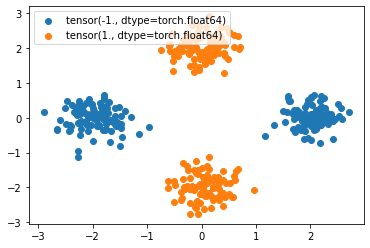

In [2]:
from functions import *

X, Y = load_data("toy_example") # four clusters

# X[:,0] += 1
print(torch.unique(Y))

# plot_data(X, Y)
K = torch.unique(Y, sorted=True)
for k in range(K.shape[0]):
    plt.scatter(X[Y==K[k], 0], X[Y==K[k], 1], label=K[k])
plt.legend()

# K-means

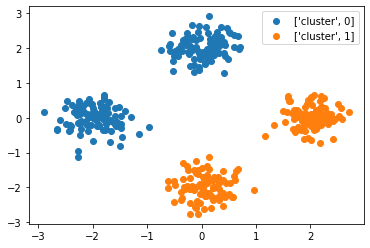

In [3]:
K = 2
kmeans = KMeans(n_clusters=K).fit(X)

# print(kmeans.labels_[:10])
# print(kmeans.labels_[:10] == 0)

for l in range(K):
    plt.scatter(X[kmeans.labels_==l,0], X[kmeans.labels_==l,1], label=['cluster',l])

plt.legend()

# Modified features and weighting for CSVM

In [4]:
N = X.shape[0]

# pre-processing
I_Nx1 = torch.ones(N,1)
X_with_ones = torch.cat((X,I_Nx1),dim=1)

D = X_with_ones.shape[1]

# global regularization
# larger the lamb, less global regularization effect
# smaller the lamb, larger global regulatization effect
lamb = 1e-5

X_hat = torch.zeros(N,D*(K+1), dtype=X.dtype, device=X.device)
X_hat[:,:D] = 1/np.sqrt(lamb)*X_with_ones

for l in range(K):
    idl = kmeans.labels_ == l

    X_hat[idl, (D*(l+1)):(D*(l+2))] = X_with_ones[idl,:]

In [5]:
# Train linear svm
Csvc = SVC(C=1,kernel='linear')
clf = Csvc.fit(X_hat,Y)

In [6]:
W_hat = torch.tensor(clf.coef_, dtype=X.dtype)

# W = 1/np.sqrt(lamb)*W_hat[0,:D]
W = W_hat[0,:D]

Wl = torch.zeros(D,K, dtype=X.dtype)
for l in range(K):
    Wl[:,l] = W_hat[0,(D*(1+l)):(D*(l+2))] + W

# Plotting

Cluster 

Prediction

Hyperplane
- Global 
- Local 

In [7]:
def plot_hyperplane(W,x_min,x_max, plane_name):
    w1 = W[0]
    w2 = W[1]
    b = W[2]

    line_x = torch.tensor([x_min,x_max])
    line_y_W = -w1/w2*line_x - b/w2

    plt.plot(line_x, line_y_W, label=plane_name)

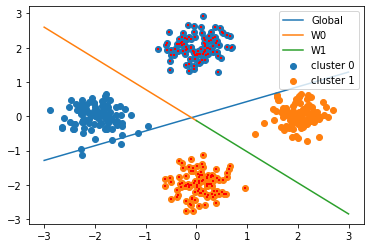

In [8]:
plot_hyperplane(W, -3, 3, 'Global')
plot_hyperplane(Wl[:,0], -3, 0, 'W0')
plot_hyperplane(Wl[:,1], 0, 3, 'W1')

for l in range(K):
    inl = kmeans.labels_ == l

    plt.scatter(X[inl,0], X[inl,1], label='cluster {}'.format(l))

    X_in_cluster_l = X_with_ones[inl,:]
    posIdx = torch.matmul(X_in_cluster_l, Wl[:,l]) > 0

    plt.scatter(X_in_cluster_l[posIdx,0], X_in_cluster_l[posIdx,1], s=5, c='r', marker='+')


plt.legend()

# red dot in the scatter represnet the data with y==1 

# LSVM on the whole dataset

In [9]:
svc_simple = SVC(C=1,kernel='linear')
clf_simple = svc_simple.fit(X_with_ones,Y)

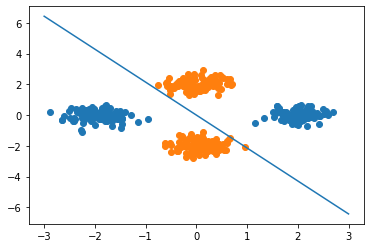

In [10]:
plot_data(X, Y)
plot_hyperplane(clf_simple.coef_[0], -3,3,'simple')